<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LGBMRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
print(df.index.is_monotonic)

True


C:\Users\palni\AppData\Local\Temp/ipykernel_18180/1337327708.py:1: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  print(df.index.is_monotonic)


In [5]:
df.sort_index(inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [8]:
df.isna().sum()/len(df)*100

num_orders    0.0
dtype: float64

In [9]:
#check
#for i in df.columns:
print(df.loc[df['num_orders'] == 0].count()/len(df)*100)

num_orders    2.026721
dtype: float64


In [10]:
df[df['num_orders']==0].head()

,num_orders
datetime,
2018-03-01 05:20:00,0
2018-03-01 05:40:00,0
2018-03-01 05:50:00,0
2018-03-01 06:00:00,0
2018-03-01 06:10:00,0


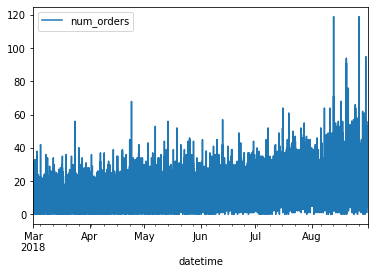

In [11]:
df.plot();

In [12]:
df = df.resample('1H').sum()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [14]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


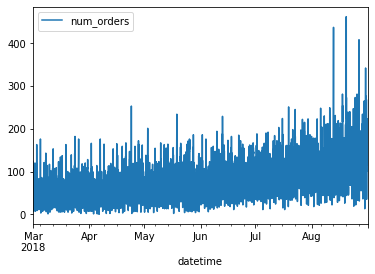

In [15]:
df.plot();

**Вывод:**
Данные подготовлены, выполнено ресемплирование по одному часу. Пропусков или аномальных значений не обнаружено.

## Анализ

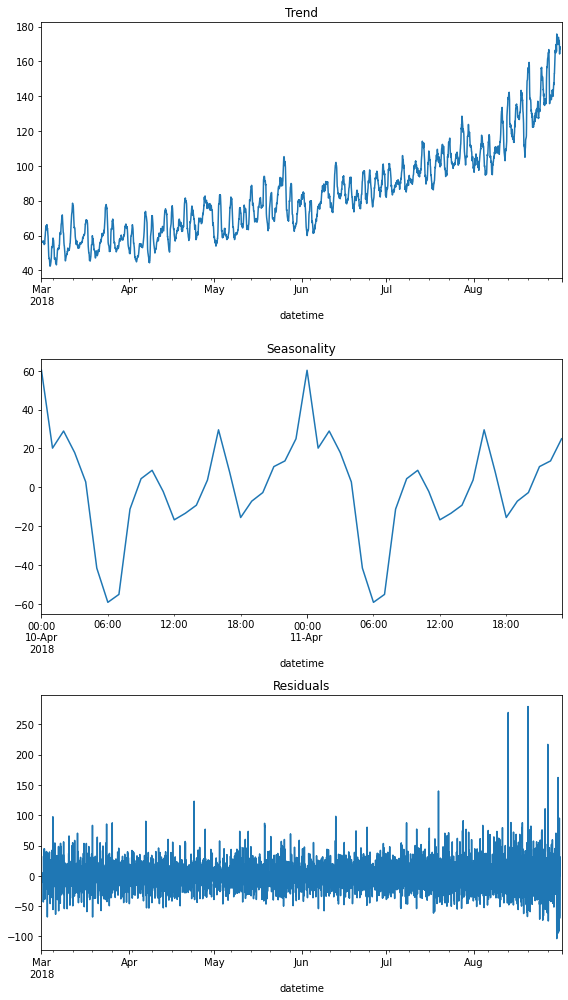

In [16]:
decompose = seasonal_decompose(df)

plt.figure(figsize=(8, 14))
plt.subplot(311)

decompose.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decompose.seasonal['2018-04-10':'2018-04-11'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decompose.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

**Вывод**

- Данные показывают количество заказов такси с 01.03.2018 по 31.08.08.2018, данные разбиты по часам
- Монотонность данных выполняется, хронологический порядок верный
- Ряд нестационарный, скользящее среднее изменяется
- Количество заказов плавно увеличивается с начала лета, скорее всего это означает развитие компании
- Ожидаемо больше заказов в часы пик и ближе к ночи (когда не ходит общественный траспорт)

**Скользящее среднее**

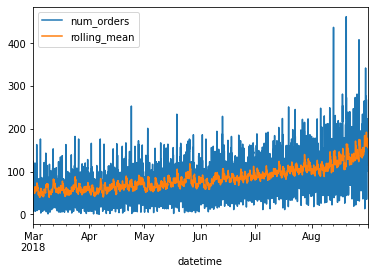

In [17]:
df['rolling_mean'] = df.rolling(20).mean()
df.plot();

## Обучение

**Создание признаков**

In [18]:
def make_features(df, max_lag, rolling_mean_size):
#    df['year'] = df.index.year
#    df['month'] = df.index.month
#    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(window=rolling_mean_size).mean()

make_features(df, 25, 25)
display(df.head())

,num_orders,rolling_mean,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<s><div class="alert alert-danger">
<b>1 Комментарий ревьюера ❌:</b> 
    
Некоторые признаки для обучения не подходят:
* `year` - константный признак. У нас данные только за 2018 год
* `month` содержит только уникальные значения, а тренд отслеживается и без этого признака
* Сам по себе `day` вряд ли влияет на кол-во заказов (есть ли тенденция на увеличение/уменьшение числа заказов в течение месяца?). `dayofweek` кажется более полезным (стоит изучить неделю)

**Разделение выборок**

In [19]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

train = train.dropna()

train_features = train.drop(['num_orders'], axis=1)
train_target = train['num_orders']

test_features = test.drop(['num_orders'], axis=1)
test_target = test['num_orders']

### LinearRegression

In [20]:
linreg_model = LinearRegression()

linreg_model.fit(train_features, train_target)
train_predict=linreg_model.predict(train_features)

Linearresult=mean_squared_error(train_target, train_predict, squared=False)
print("RMSE обучающей выборки:", Linearresult)

RMSE обучающей выборки: 25.920717689759236


### CatBoost

In [21]:
param_grid = {'l2_leaf_reg':[5,10,15],
              'learning_rate': [0.05,0.1,0.15],
              }
CatBoost_model = CatBoostRegressor(loss_function="RMSE", iterations=10)

tscv = TimeSeriesSplit(n_splits=5) 
                                  
parameters_CatBoost = GridSearchCV(estimator = CatBoost_model,param_grid = param_grid,n_jobs=1,scoring= 'neg_root_mean_squared_error',cv=tscv)

parameters_CatBoost.fit(train_features, train_target)
print('best params\n', parameters_CatBoost.best_params_)
print('best RMSE\n', -parameters_CatBoost.best_score_)

C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.1368061	total: 164ms	remaining: 1.47s
1:	learn: 28.5709170	total: 165ms	remaining: 660ms
2:	learn: 27.9474005	total: 166ms	remaining: 388ms
3:	learn: 27.4352274	total: 168ms	remaining: 252ms
4:	learn: 26.9501630	total: 169ms	remaining: 169ms
5:	learn: 26.4702360	total: 171ms	remaining: 114ms
6:	learn: 26.0112728	total: 172ms	remaining: 73.8ms
7:	learn: 25.5474987	total: 174ms	remaining: 43.4ms
8:	learn: 25.2003902	total: 175ms	remaining: 19.5ms
9:	learn: 24.7808200	total: 177ms	remaining: 0us
0:	learn: 29.7174318	total: 6.99ms	remaining: 62.9ms
1:	learn: 29.1374510	total: 8.72ms	remaining: 34.9ms
2:	learn: 28.5800301	total: 10.4ms	remaining: 24.2ms
3:	learn: 28.0580008	total: 11.9ms	remaining: 17.9ms
4:	learn: 27.5306860	total: 13.4ms	remaining: 13.4ms
5:	learn: 27.0614884	total: 14.9ms	remaining: 9.92ms
6:	learn: 26.6094472	total: 16.4ms	remaining: 7.04ms
7:	learn: 26.1761353	total: 18ms	remaining: 4.5ms
8:	learn: 25.8552595	total: 19.6ms	remaining: 2.17ms
9:	learn: 25.43

C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embeddin

1:	learn: 33.3609504	total: 5.02ms	remaining: 20.1ms
2:	learn: 32.7192146	total: 7.42ms	remaining: 17.3ms
3:	learn: 32.0855614	total: 9.62ms	remaining: 14.4ms
4:	learn: 31.5042109	total: 11.9ms	remaining: 11.9ms
5:	learn: 30.9197885	total: 14.1ms	remaining: 9.43ms
6:	learn: 30.3963564	total: 22.8ms	remaining: 9.78ms
7:	learn: 29.8953899	total: 25.7ms	remaining: 6.42ms
8:	learn: 29.4492040	total: 28ms	remaining: 3.11ms
9:	learn: 29.0083856	total: 31.3ms	remaining: 0us
0:	learn: 28.6040950	total: 1.78ms	remaining: 16ms
1:	learn: 27.4883517	total: 3.09ms	remaining: 12.4ms
2:	learn: 26.4615434	total: 4.52ms	remaining: 10.5ms
3:	learn: 25.5896181	total: 5.77ms	remaining: 8.66ms
4:	learn: 24.7677819	total: 7.07ms	remaining: 7.07ms
5:	learn: 24.1219328	total: 8.39ms	remaining: 5.6ms
6:	learn: 23.4392991	total: 9.74ms	remaining: 4.17ms
7:	learn: 22.7769302	total: 11.1ms	remaining: 2.78ms
8:	learn: 22.1835521	total: 12.5ms	remaining: 1.39ms
9:	learn: 21.6514629	total: 13.9ms	remaining: 0us
0:	l

C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embeddin

0:	learn: 33.2979183	total: 2.64ms	remaining: 23.8ms
1:	learn: 32.0788420	total: 4.9ms	remaining: 19.6ms
2:	learn: 30.9461901	total: 7.28ms	remaining: 17ms
3:	learn: 29.9547355	total: 9.41ms	remaining: 14.1ms
4:	learn: 28.9640707	total: 11.8ms	remaining: 11.8ms
5:	learn: 28.1146963	total: 13.9ms	remaining: 9.24ms
6:	learn: 27.4151870	total: 16ms	remaining: 6.84ms
7:	learn: 26.8447874	total: 18.1ms	remaining: 4.53ms
8:	learn: 26.2881293	total: 20.2ms	remaining: 2.25ms
9:	learn: 25.8347148	total: 22.3ms	remaining: 0us
0:	learn: 28.0845289	total: 1.53ms	remaining: 13.8ms
1:	learn: 26.4994539	total: 2.93ms	remaining: 11.7ms
2:	learn: 24.9168506	total: 4.18ms	remaining: 9.77ms
3:	learn: 23.8127585	total: 5.5ms	remaining: 8.26ms
4:	learn: 22.9200834	total: 7.01ms	remaining: 7.01ms
5:	learn: 22.0221202	total: 8.44ms	remaining: 5.63ms
6:	learn: 21.2149352	total: 9.87ms	remaining: 4.23ms
7:	learn: 20.5819145	total: 11.3ms	remaining: 2.81ms
8:	learn: 20.0879878	total: 12.6ms	remaining: 1.4ms
9:	

C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embeddin

1:	learn: 30.8591588	total: 5.12ms	remaining: 20.5ms
2:	learn: 29.3050906	total: 7.35ms	remaining: 17.1ms
3:	learn: 28.0547670	total: 9.57ms	remaining: 14.4ms
4:	learn: 26.9849410	total: 11.9ms	remaining: 11.9ms
5:	learn: 26.1354754	total: 14.2ms	remaining: 9.44ms
6:	learn: 25.4459295	total: 16.7ms	remaining: 7.16ms
7:	learn: 24.9061507	total: 18.8ms	remaining: 4.7ms
8:	learn: 24.4690884	total: 20.9ms	remaining: 2.32ms
9:	learn: 24.1190993	total: 23ms	remaining: 0us
0:	learn: 29.1952362	total: 8.02ms	remaining: 72.2ms
1:	learn: 28.6517776	total: 9.42ms	remaining: 37.7ms
2:	learn: 28.0666355	total: 10.7ms	remaining: 24.9ms
3:	learn: 27.6194485	total: 12ms	remaining: 17.9ms
4:	learn: 27.1790296	total: 13.3ms	remaining: 13.3ms
5:	learn: 26.7360401	total: 14.7ms	remaining: 9.78ms
6:	learn: 26.3961221	total: 16.1ms	remaining: 6.89ms
7:	learn: 26.0074093	total: 17.3ms	remaining: 4.33ms
8:	learn: 25.6510172	total: 18.7ms	remaining: 2.08ms
9:	learn: 25.2485021	total: 20.1ms	remaining: 0us
0:	l

C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embeddin

0:	learn: 34.0644060	total: 2.46ms	remaining: 22.1ms
1:	learn: 33.4158986	total: 4.85ms	remaining: 19.4ms
2:	learn: 32.7999750	total: 7.07ms	remaining: 16.5ms
3:	learn: 32.1886157	total: 9.34ms	remaining: 14ms
4:	learn: 31.6337761	total: 11.6ms	remaining: 11.6ms
5:	learn: 31.0629150	total: 13.9ms	remaining: 9.29ms
6:	learn: 30.5551564	total: 17.3ms	remaining: 7.42ms
7:	learn: 30.0660042	total: 19.7ms	remaining: 4.93ms
8:	learn: 29.6342998	total: 22.1ms	remaining: 2.45ms
9:	learn: 29.1976906	total: 24.4ms	remaining: 0us
0:	learn: 28.7181055	total: 1.52ms	remaining: 13.7ms
1:	learn: 27.7134249	total: 2.93ms	remaining: 11.7ms
2:	learn: 26.6151163	total: 4.28ms	remaining: 9.99ms
3:	learn: 25.8362909	total: 5.68ms	remaining: 8.53ms
4:	learn: 25.1310757	total: 7.01ms	remaining: 7.01ms
5:	learn: 24.3871455	total: 8.35ms	remaining: 5.57ms
6:	learn: 23.7607902	total: 9.66ms	remaining: 4.14ms
7:	learn: 23.1036673	total: 11.1ms	remaining: 2.77ms
8:	learn: 22.6014639	total: 12.4ms	remaining: 1.38m

C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embeddin

6:	learn: 26.5305161	total: 14.4ms	remaining: 6.16ms
7:	learn: 25.9642123	total: 16.6ms	remaining: 4.16ms
8:	learn: 25.4353007	total: 18.8ms	remaining: 2.08ms
9:	learn: 25.0043763	total: 20.8ms	remaining: 0us
0:	learn: 33.3456048	total: 2.47ms	remaining: 22.2ms
1:	learn: 32.1790909	total: 4.75ms	remaining: 19ms
2:	learn: 31.0906787	total: 6.87ms	remaining: 16ms
3:	learn: 30.1275132	total: 8.97ms	remaining: 13.5ms
4:	learn: 29.1885149	total: 11.1ms	remaining: 11.1ms
5:	learn: 28.3580633	total: 13.3ms	remaining: 8.86ms
6:	learn: 27.7013963	total: 15.3ms	remaining: 6.57ms
7:	learn: 27.0931675	total: 17.4ms	remaining: 4.36ms
8:	learn: 26.5681833	total: 19.5ms	remaining: 2.17ms
9:	learn: 26.1455141	total: 21.5ms	remaining: 0us
0:	learn: 28.2510480	total: 2.83ms	remaining: 25.5ms
1:	learn: 26.7840173	total: 4.23ms	remaining: 16.9ms
2:	learn: 25.3015464	total: 5.49ms	remaining: 12.8ms
3:	learn: 24.3279988	total: 6.7ms	remaining: 10ms
4:	learn: 23.5573346	total: 8.02ms	remaining: 8.02ms
5:	lea

C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embeddin

1:	learn: 29.7419948	total: 4.74ms	remaining: 18.9ms
2:	learn: 28.3318648	total: 6.9ms	remaining: 16.1ms
3:	learn: 27.1571573	total: 8.94ms	remaining: 13.4ms
4:	learn: 26.1107050	total: 11.1ms	remaining: 11.1ms
5:	learn: 25.2863578	total: 13.1ms	remaining: 8.76ms
6:	learn: 24.6858592	total: 15.4ms	remaining: 6.58ms
7:	learn: 24.1350507	total: 17.4ms	remaining: 4.35ms
8:	learn: 23.5551059	total: 19.5ms	remaining: 2.16ms
9:	learn: 23.1223257	total: 21.6ms	remaining: 0us
0:	learn: 32.6482996	total: 2.46ms	remaining: 22.2ms
1:	learn: 30.9937733	total: 4.78ms	remaining: 19.1ms
2:	learn: 29.5160436	total: 6.96ms	remaining: 16.2ms
3:	learn: 28.2516713	total: 8.98ms	remaining: 13.5ms
4:	learn: 27.2251167	total: 11.2ms	remaining: 11.2ms
5:	learn: 26.3994377	total: 13.3ms	remaining: 8.83ms
6:	learn: 25.7566071	total: 15.3ms	remaining: 6.57ms
7:	learn: 25.2178887	total: 17.5ms	remaining: 4.37ms
8:	learn: 24.7773768	total: 19.7ms	remaining: 2.18ms
9:	learn: 24.4242068	total: 21.7ms	remaining: 0us


C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embeddin

1:	learn: 32.1193956	total: 9.61ms	remaining: 38.5ms
2:	learn: 31.4853113	total: 11.8ms	remaining: 27.6ms
3:	learn: 30.9280667	total: 13.8ms	remaining: 20.7ms
4:	learn: 30.3879636	total: 15.9ms	remaining: 15.9ms
5:	learn: 29.8914903	total: 18.1ms	remaining: 12.1ms
6:	learn: 29.4449161	total: 20.3ms	remaining: 8.71ms
7:	learn: 29.0229959	total: 22.4ms	remaining: 5.59ms
8:	learn: 28.6343347	total: 24.4ms	remaining: 2.71ms
9:	learn: 28.2107023	total: 26.4ms	remaining: 0us
0:	learn: 34.0867986	total: 2.54ms	remaining: 22.9ms
1:	learn: 33.4644824	total: 4.81ms	remaining: 19.2ms
2:	learn: 32.8601362	total: 6.94ms	remaining: 16.2ms
3:	learn: 32.2700126	total: 9.04ms	remaining: 13.6ms
4:	learn: 31.6996632	total: 11.2ms	remaining: 11.2ms
5:	learn: 31.1399853	total: 13.3ms	remaining: 8.87ms
6:	learn: 30.6909117	total: 15.4ms	remaining: 6.61ms
7:	learn: 30.2126976	total: 17.5ms	remaining: 4.38ms
8:	learn: 29.7943604	total: 19.8ms	remaining: 2.2ms
9:	learn: 29.3606597	total: 22.1ms	remaining: 0us


C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embeddin

9:	learn: 24.2375714	total: 34.2ms	remaining: 0us
0:	learn: 32.0008348	total: 9.86ms	remaining: 88.7ms
1:	learn: 30.9502804	total: 11.9ms	remaining: 47.8ms
2:	learn: 29.8722894	total: 13.9ms	remaining: 32.5ms
3:	learn: 28.9280277	total: 15.8ms	remaining: 23.7ms
4:	learn: 28.0692417	total: 17.8ms	remaining: 17.8ms
5:	learn: 27.3347516	total: 19.7ms	remaining: 13.1ms
6:	learn: 26.7050985	total: 21.7ms	remaining: 9.3ms
7:	learn: 26.1463336	total: 23.7ms	remaining: 5.93ms
8:	learn: 25.6428823	total: 25.7ms	remaining: 2.85ms
9:	learn: 25.1742634	total: 27.6ms	remaining: 0us
0:	learn: 33.3892847	total: 2.48ms	remaining: 22.3ms
1:	learn: 32.2655549	total: 4.72ms	remaining: 18.9ms
2:	learn: 31.2145617	total: 6.89ms	remaining: 16.1ms
3:	learn: 30.2761439	total: 8.96ms	remaining: 13.4ms
4:	learn: 29.3570090	total: 11ms	remaining: 11ms
5:	learn: 28.5304130	total: 13ms	remaining: 8.68ms
6:	learn: 27.8700344	total: 15.1ms	remaining: 6.46ms
7:	learn: 27.2735995	total: 17.2ms	remaining: 4.29ms
8:	lea

C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
C:\Users\palni\practicum\practicum_env\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embeddin

1:	learn: 28.7391043	total: 4.88ms	remaining: 19.5ms
2:	learn: 27.5821743	total: 6.96ms	remaining: 16.3ms
3:	learn: 26.4116430	total: 9.06ms	remaining: 13.6ms
4:	learn: 25.5630021	total: 11ms	remaining: 11ms
5:	learn: 24.7591639	total: 13ms	remaining: 8.66ms
6:	learn: 24.1125070	total: 15.1ms	remaining: 6.49ms
7:	learn: 23.5672730	total: 17.1ms	remaining: 4.29ms
8:	learn: 22.9839666	total: 18.9ms	remaining: 2.1ms
9:	learn: 22.5728926	total: 20.7ms	remaining: 0us
0:	learn: 31.3360270	total: 2.34ms	remaining: 21.1ms
1:	learn: 29.8668807	total: 4.47ms	remaining: 17.9ms
2:	learn: 28.4744438	total: 6.41ms	remaining: 14.9ms
3:	learn: 27.3274867	total: 8.41ms	remaining: 12.6ms
4:	learn: 26.3175350	total: 10.4ms	remaining: 10.4ms
5:	learn: 25.5021263	total: 12.3ms	remaining: 8.19ms
6:	learn: 24.8802698	total: 14.9ms	remaining: 6.38ms
7:	learn: 24.3534159	total: 16.9ms	remaining: 4.24ms
8:	learn: 23.9168545	total: 19ms	remaining: 2.11ms
9:	learn: 23.5443417	total: 21.1ms	remaining: 0us
0:	learn

In [22]:
CatBoost_model = CatBoostRegressor(l2_leaf_reg=20,n_estimators=50, max_depth=5,loss_function = 'RMSE',eval_metric = 'RMSE')
CatBoost_model.fit(train_features, train_target,verbose=10)

train_predict=CatBoost_model.predict(train_features)

CatBoost_result=mean_squared_error(train_target, train_predict, squared=False)
print("RMSE обучающей выборки:", CatBoost_result)

0:	learn: 38.1834520	total: 11.8ms	remaining: 579ms
10:	learn: 34.3108888	total: 28.9ms	remaining: 102ms
20:	learn: 31.5654020	total: 46ms	remaining: 63.5ms
30:	learn: 29.6944574	total: 63.5ms	remaining: 38.9ms
40:	learn: 28.2922193	total: 80.2ms	remaining: 17.6ms
49:	learn: 27.4241459	total: 95ms	remaining: 0us
RMSE обучающей выборки: 27.424145912624603


### LGBMRegressor

In [23]:
param_grid = {'max_depth':[5,10,15],
              'learning_rate': [0.05,0.1,0.15],
              }
LGBM_model = LGBMRegressor()
                                  
tscv = TimeSeriesSplit(n_splits=5) 

parameters_LGBM = GridSearchCV(estimator = LGBM_model,param_grid = param_grid,n_jobs=-1,verbose=1,scoring= 'neg_root_mean_squared_error',cv=tscv)

parameters_LGBM.fit(train_features, train_target)
print('best params\n', parameters_LGBM.best_params_)
print('best RMSE\n', -parameters_LGBM.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
best params
 {'learning_rate': 0.15, 'max_depth': 5}
best RMSE
 25.54790946381748


In [24]:
LGBM_model = LGBMRegressor(num_leaves= 100, learning_rate=0.05, max_depth=15, n_estimators=100)
LGBM_model.fit(train_features, train_target, eval_metric='rmse')

train_predict=LGBM_model.predict(train_features)

LGBM_result=mean_squared_error(train_target, train_predict, squared=False)
print("RMSE обучающей выборки:", LGBM_result)

RMSE обучающей выборки: 10.401380345050166


**Сравнение**

In [25]:
result = {'Модель':['LinearRegression','CatBoost','LGBMRegressor'],
          'RMSE':[Linearresult,
                  -parameters_CatBoost.best_score_,
                  -parameters_LGBM.best_score_
                 ],
          }

result=pd.DataFrame(result)

display(result)

,Модель,RMSE
0,LinearRegression,25.920718
1,CatBoost,29.899009
2,LGBMRegressor,25.547909


**Вывод**

На обучающих выборках модель LGBMRegressor показала наилучшие результаты, будем использовать ее для финального тестирования

## Тестирование

In [26]:
test_predict=LGBM_model.predict(test_features)

LGBM_result_test=mean_squared_error(test_target, test_predict, squared=False)
print("RMSE обучающей выборки:", LGBM_result_test)

RMSE обучающей выборки: 42.79706531035531


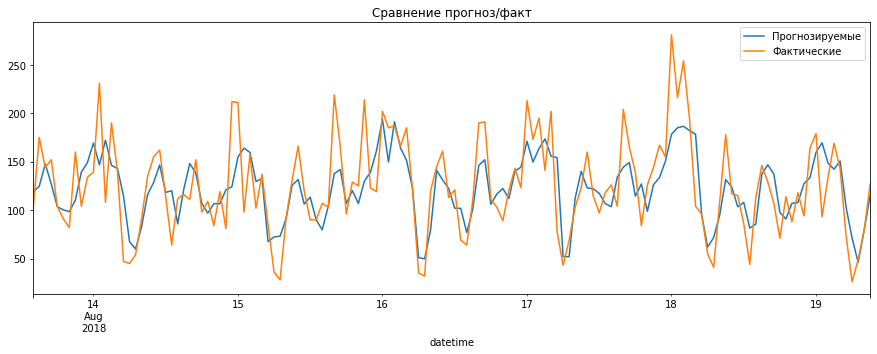

In [27]:
pd.DataFrame({'Прогнозируемые':test_predict, 'Фактические':test_target})[:140].plot(figsize=(15,5))
plt.title('Сравнение прогноз/факт')
plt.show()

## Вывод

- Данные выгружены, ресеплированы, проверена монотонность
- Проведен общий анализ, определены суточные и месячные тренды
- Созданы новые признаки для обучения моделей, подобраны параметры
- Обучены три разрличные модели машинного обучения (LinearRegression, CatBoost, LGBMRegressor), подобраны гиперпараметры
- Выбрана наилучая модель (по RMSE) и проведено ее финальное тестирование на тестовой выборке. RMSE не превышает значение, требуемое в условии

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [X]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [X]  Данные загружены и подготовлены
- [X]  Данные проанализированы
- [X]  Модель обучена, гиперпараметры подобраны
- [X]  Качество моделей проверено, выводы сделаны
- [X]  Значение *RMSE* на тестовой выборке не больше 48